In [1]:
import numpy as np
import pandas as pd

np.random.seed(27)

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Num GPUs Available:  1
2.3.0


# Set up OpenAQ, Meteostat APIs
OpenAQ: https://openaq.org/ MeteoStat: https://meteostat.net/en

Tools py-openaq: https://github.com/dhhagan/py-openaq meteostat: https://dev.meteostat.net/python/

In [2]:
import openaq
# Import Meteostat library and dependencies
from meteostat import Point, Hourly, Daily

openaq = openaq.OpenAQ(version="v2")

class Location:
    def __init__(self, name, lat, lon):
        self.name = name
        self.lat = lat
        self.lon = lon


locations_IT = []

cities = openaq.cities(country="IT", limit=100000, df=True)["city"]

for city in cities:
    print(city) 
    try:
        res = openaq.locations(city=city, df=True)[["coordinates.latitude","coordinates.longitude"]].mean()
    
        locations_IT.append(Location(city, res["coordinates.latitude"], res["coordinates.longitude"]))
    except:
        print("-----------Skipped {}-----------".format(city))

Alessandria
ALFONSINE
Ancona
Arezzo
Ascoli Piceno
Asti
Avellino
Bari
Barletta-Andria-Trani
Belluno
Benevento
Bergamo
Biella
Bologna
BOLOGNA
Bolzano/Bozen
Brescia
Brindisi
Cagliari
Campobasso
Carbonia-Iglesias
CARPI
Caserta
Catanzaro
CENTO
CESENA
Chiesanuova
Civitavecchia
COLORNO
Como
Cosenza
Cremona
Crotone
Cuneo
FAENZA
Ferrara
FERRARA
FIORANO MODENESE
Firenze
Foggia
FORLI'
Forli'-Cesena
Frosinone
Genova
Grosseto
GUASTALLA
IMOLA
JOLANDA DI SAVOIA
LANGHIRANO
L'Aquila
Latina
Lecce
Lecco
Livorno
Lodi
Lucca
LUGAGNANO VAL D'ARDA
Macerata
Mantova
Massa-Carrara
Matera
MEZZANI
Milano
MIRANDOLA
Modena
MODENA
MOLINELLA
Monza E Della Brianza
Napoli
Novara
Nuoro
Olbia-Tempio
Oristano
OSTELLATO
Padova
Parma
PARMA
Pavia
Perugia
Pesaro E Urbino
Pescara
Piacenza
PIACENZA
Pisa
Pistoia
PORRETTA TERME
Potenza
Prato
Ravenna
RAVENNA
Reggio Di Calabria
Reggio Nell'Emilia
REGGIO NELL'EMILIA
Rieti
Rimini
RIMINI
Roma
Rovigo
Salerno
SAN CLEMENTE
SAN LAZZARO DI SAVENA
SAN LEO
Sassari
SASSUOLO
SAVIGNANO SUL RUBIC

In [3]:
from datetime import datetime, timedelta
import time

# Napoli index 68
# Trento index 113

# Select Napoli because it holds most sensors and less holes
selected_location = locations_IT[68]
print(selected_location.name)
# Format coordinates to align with OpenAQ standards
coordinates = "{},{}".format(round(selected_location.lat, 8), round(selected_location.lon, 8))

now = datetime(2021,10,1)

# For some reason the OpenAQ API accepts the date only in this way
date_from = datetime(2020 , 5, 20)
date_to = datetime(now.year, now.month, now.day) + timedelta(days=1)

print("Time Range: {} - {}".format(date_from, date_to))

selected_pollutants = ['pm25','pm10','no2','o3','so2','co']

# Create empty Dataframe
df_pollutants = pd.DataFrame(columns=selected_pollutants)

# getPollutants()

for pollutant in selected_pollutants:
    locations = openaq.locations(coordinates=coordinates, parameter=pollutant, radius=20000, df=True, has_geo=True)

    dfs_array = []
    for location in locations["id"]:
        try:
            time.sleep(3)
            df = openaq.measurements(location=location,
                                     date_from=date_from.date(), 
                                     date_to=date_to.date(),
                                     limit=100000, 
                                     parameter=pollutant,
                                     df=True,
                                     sort="asc")[["value"]].resample('H').mean()
            
            dfs_array.append(df)
            print("Added location {}".format(location))
        
        except:
            print("Skipped location {}".format(location))
    
    dfs_array = sorted(dfs_array,key=lambda x:x.index[0])
    df_pollutants[pollutant] = pd.concat(dfs_array, join="outer", axis = 1, sort=False).mean(axis=1)
    print("Added pollutant {}".format(pollutant))
    print("---------------------")

print("Data fetching completed!")

df_pollutants

Napoli
Time Range: 2020-05-20 00:00:00 - 2021-10-02 00:00:00
Added location 8444
Added location 8410
Added pollutant pm25
---------------------
Added location 8444
Added location 8410
Added location 8411
Added pollutant pm10
---------------------
Added location 8409
Added location 8444
Added location 8410
Added location 8411
Added location 8597
Added location 8408
Added pollutant no2
---------------------
Added location 8408
Added pollutant o3
---------------------
Added location 8410
Added location 8411
Added pollutant so2
---------------------
Added location 8410
Added location 8411
Added location 8444
Added location 8408
Added pollutant co
---------------------
Data fetching completed!


pm25       pm10        no2     o3    so2     co
date.local                                                           
2020-05-20 02:00:00   5.10  17.000000  10.503333  54.00  0.555  297.5
2020-05-20 03:00:00  13.00  14.850000   9.445000  62.58  0.565  340.0
2020-05-20 04:00:00    NaN        NaN  13.510000    NaN  0.380  290.0
2020-05-20 05:00:00  12.70  23.100000   4.930000    NaN    NaN    NaN
2020-05-20 06:00:00   5.55  18.800000   7.423333  42.21    NaN  215.0
...                    ...        ...        ...    ...    ...    ...
2021-10-01 22:00:00  21.65  40.433333  68.230000  32.60  4.180  690.0
2021-10-01 23:00:00  21.75  34.200000  63.921667    NaN  3.460  750.0
2021-10-02 00:00:00  26.55  40.933333  56.923333  20.29  3.335  650.0
2021-10-02 01:00:00  24.05  38.966667  51.535000  21.14  3.995  562.5
2021-10-02 02:00:00  21.05  39.166667  52.080000  19.27  3.595  557.5

[12001 rows x 6 columns]

array([<AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>], dtype=object)

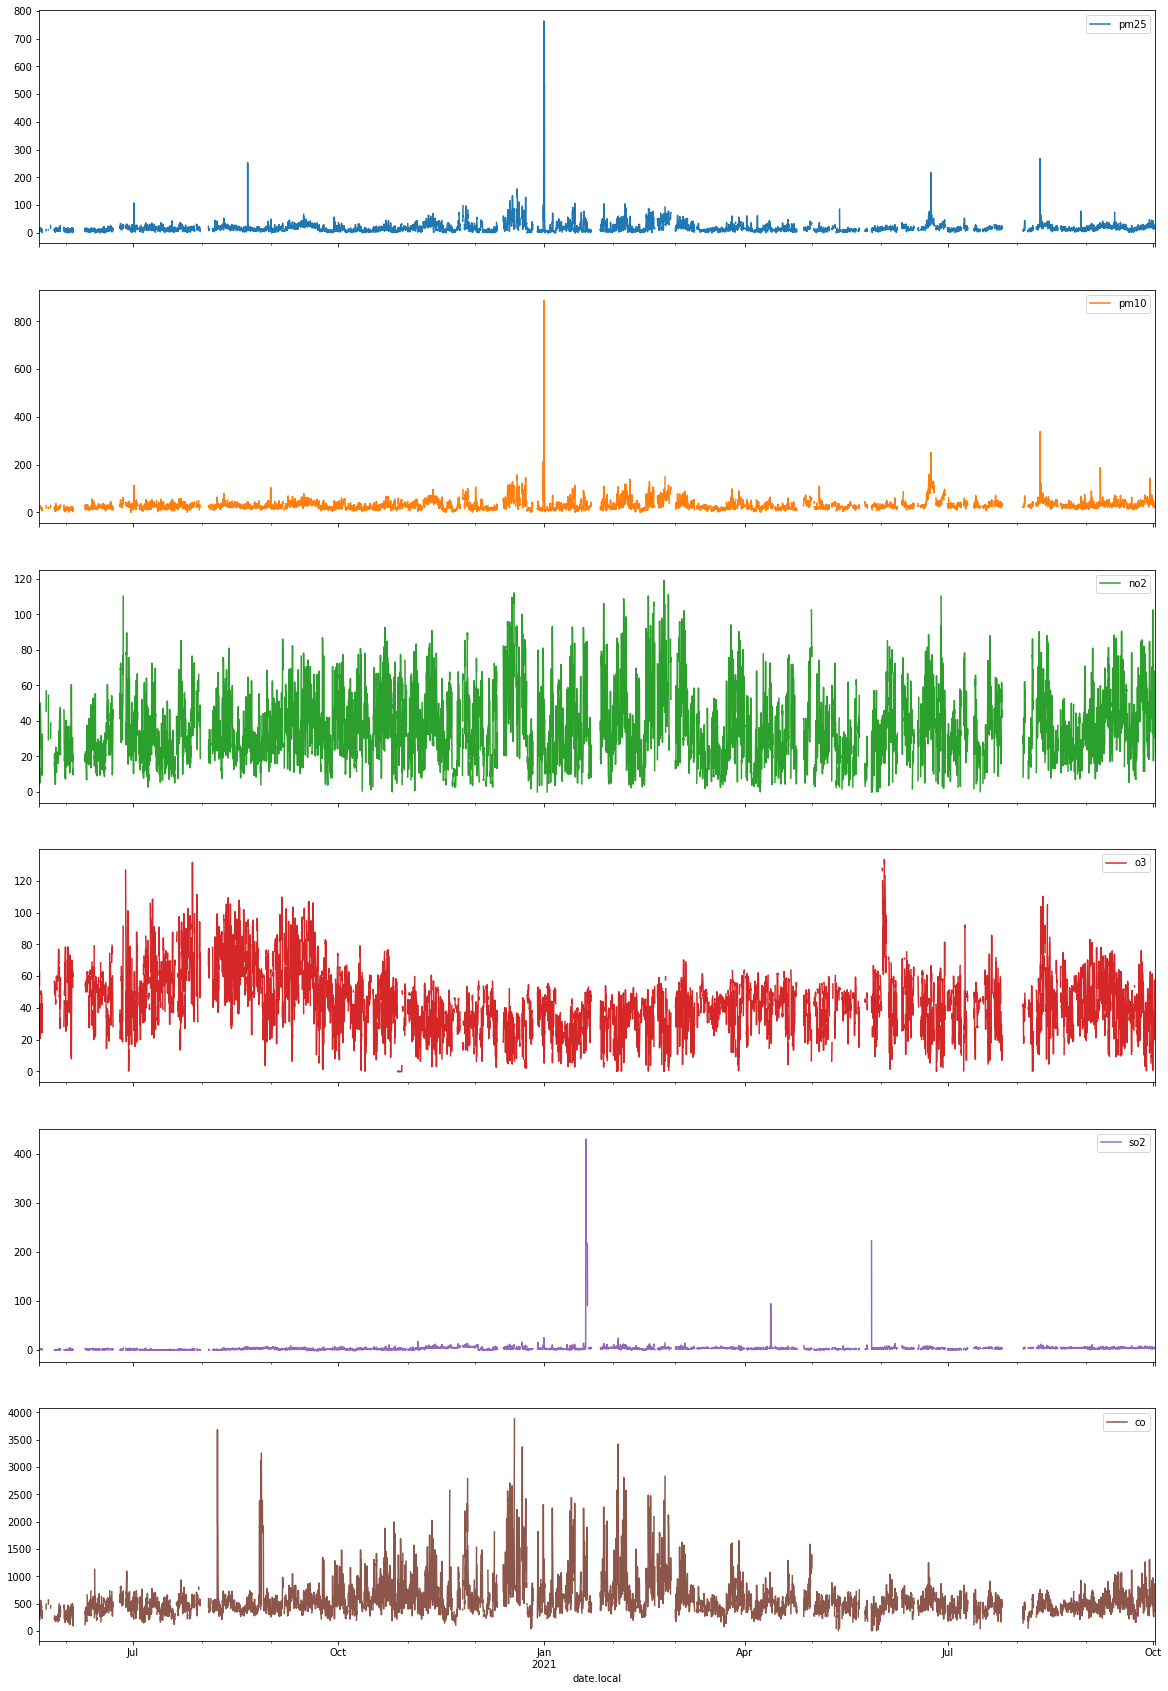

In [4]:
df_pollutants.plot(figsize=(20,30), subplots=True)

In [5]:
# Create Point for Napoli
# We will give the median between the maximum: 17m, minimum: 0m elevation of Napoli 

loc = Point(selected_location.lat, selected_location.lon, 9.5)

# temp  The air temperature in °C
# dwpt  The dew point in °C
# rhum  The relative humidity in percent (%)
# prcp  The one hour precipitation total in mm
# snow  The snow depth in mm
# wdir  The average wind direction in degrees (°)
# wspd  The average wind speed in km/h
# wpgt  The peak wind gust in km/h
# pres  The average sea-level air pressure in hPa
# tsun  The one hour sunshine total in minutes (m)
# coco  The weather condition code

# Get hourly data
df_weather = Hourly(loc=loc, start=date_from, end=date_to)
df_weather = df_weather.normalize()
df_weather = df_weather.fetch()

# Remove columns that hold no values
weather_features = ['dwpt', 'prcp', 'snow', 'wdir', 'wpgt', 'tsun']
df_weather.drop(weather_features, axis=1, inplace=True)
# df_weather = df_weather.interpolate(method='time')

final_df = df_pollutants.merge(df_weather, left_index=True, right_index=True)

final_df

pm25       pm10        no2     o3    so2          co  \
2020-05-20 02:00:00   5.10  17.000000  10.503333  54.00  0.555  297.500000   
2020-05-20 03:00:00  13.00  14.850000   9.445000  62.58  0.565  340.000000   
2020-05-20 04:00:00    NaN        NaN  13.510000    NaN  0.380  290.000000   
2020-05-20 05:00:00  12.70  23.100000   4.930000    NaN    NaN         NaN   
2020-05-20 06:00:00   5.55  18.800000   7.423333  42.21    NaN  215.000000   
...                    ...        ...        ...    ...    ...         ...   
2021-10-01 20:00:00  22.20  37.900000  54.292000  40.61  5.145  745.000000   
2021-10-01 21:00:00  21.45  33.700000  62.785000  36.11  4.010  866.666667   
2021-10-01 22:00:00  21.65  40.433333  68.230000  32.60  4.180  690.000000   
2021-10-01 23:00:00  21.75  34.200000  63.921667    NaN  3.460  750.000000   
2021-10-02 00:00:00  26.55  40.933333  56.923333  20.29  3.335  650.000000   

                     temp  rhum  wspd    pres  coco  
2020-05-20 02:00:00  17.4  83.3   7.5  1008.0   7.0  
2020-05-20 03:00:00  16.6  87.2   5.4  1008.2   7.0  
2020-05-20 04:00:00  16.4  88.1   9.3  1008.0   7.0  
2020-05-20 05:00:00  17.4  83.3   5.4  1008.0   7.0  
2020-05-20 06:00:00  16.7  91.8   1.9  1007.9   7.0  
...                   ...   ...   ...     ...   ...  
2021-10-01 20:00:00  21.6  61.6   6.9  1020.0   1.0  
2021-10-01 21:00:00  20.6  68.5   6.2  1019.9   1.0  
2021-10-01 22:00:00  19.6  73.0   4.4  1019.0   1.0  
2021-10-01 23:00:00  19.6  73.4   7.1  1019.0   1.0  
2021-10-02 00:00:00  19.6  69.1   6.1  1019.0   1.0  

[11999 rows x 11 columns]

## Fill any empty value

In [6]:
cols_with_Nan = final_df.columns[final_df.isnull().any()].tolist()

if cols_with_Nan:
    for col in cols_with_Nan:
        print(col)
        while(final_df[col].isnull().sum() > 0):
            final_df[col] = final_df[col].fillna(final_df[col].rolling('4D',min_periods=1).mean())
        final_df[col] = final_df[col].interpolate(method='time', limit_direction='both')
        
final_df.isnull().sum()

pm25
pm10
no2
o3
so2
co


pm25    0
pm10    0
no2     0
o3      0
so2     0
co      0
temp    0
rhum    0
wspd    0
pres    0
coco    0
dtype: int64

# Calculate AQI for each pollutant

EEA AQI TABLE

| Key | Category | PM2,5 μg/m³ | PM10 μg/m³ | NO2 ppb | O3 ppb | SO2 ppb
| :- | :- | :- | :- | :- | :- | :- |
| 1 | Good | 0-10 | 0-20 | 0-40 | 0-50 | 0-100 | 
| 2 | Fair | 10-20 | 20-40 | 40-90 | 50-100 | 100-200 | 
| 3 | Moderate | 20-25 | 40-50 | 90-120 | 100-130 | 200-350 | 
| 4 | Poor | 25-50 | 50-100 | 120-230 | 130-240 | 350-500 |
| 5 | Very Poor | 50-75 | 100-150 | 230-340 | 240-380 | 500-750 |
| 6 | Extremely Poor | 75-800 | 150-1200 | 340-1000 | 380-800 | 750-1250 |

We will use key numbers for each category:

Good: 1
Fair: 2
Moderate: 3
Poor: 4
Very Poor: 5
Extremely Poor: 6

### Define functions to calculate AQI for each pollutant

In [7]:
def calcPM25(x):
    if x <= 10:
        return 1
    elif x >=11 and x <= 20:
        return 2
    elif x >=21 and x <= 25:
        return 3
    elif x >=26 and x <= 50:
        return 4
    elif x >=51 and x <= 75:
        return 5
    elif x >=76:
        return 6
    else:
        return 1
    
def calcPM10(x):
    if x <= 20:
        return 1
    elif x >=21 and x <= 40:
        return 2
    elif x >=41 and x <= 50:
        return 3
    elif x >=51 and x <= 100:
        return 4
    elif x >=101 and x <= 150:
        return 5
    elif x >=151:
        return 6
    else:
        return 1
    
def calcNO2(x):
    if x <= 40:
        return 1
    elif x >=41 and x <= 90:
        return 2
    elif x >=91 and x <= 120:
        return 3
    elif x >=121 and x <= 230:
        return 4
    elif x >=231 and x <= 340:
        return 5
    elif x >=341:
        return 6
    else:
        return 1
    
def calcO3(x):
    if x <= 50:
        return 1
    elif x >=51 and x <= 100:
        return 2
    elif x >=101 and x <= 130:
        return 3
    elif x >=131 and x <= 240:
        return 4
    elif x >=241 and x <= 380:
        return 5
    elif x >=381:
        return 6
    else:
        return 1
    
def calcSO2(x):
    if x <= 100:
        return 1
    elif x >=101 and x <= 200:
        return 2
    elif x >=201 and x <= 350:
        return 3
    elif x >=351 and x <= 500:
        return 4
    elif x >=501 and x <= 750:
        return 5
    elif x >=751:
        return 6
    else:
        return 1

    
final_df["pm25_AQI"] = final_df["pm25"].apply(lambda x: calcPM25(x))
final_df["pm10_AQI"] = final_df["pm10"].apply(lambda x: calcPM10(x))
final_df["no2_AQI"] = final_df["no2"].apply(lambda x: calcNO2(x))
final_df["o3_AQI"] = final_df["o3"].apply(lambda x: calcO3(x))
final_df["so2_AQI"] = final_df["so2"].apply(lambda x: calcSO2(x))

In [8]:
# final_df["overall_AQI"] = max(final_df[["pm25_AQI", "pm10_AQI", "o3_AQI", "so2_AQI", "co_AQI"]])
final_df["overall_AQI"] = final_df[["pm25_AQI","pm10_AQI","no2_AQI","o3_AQI","so2_AQI"]].max(axis=1)

final_df

pm25       pm10        no2         o3    so2  \
2020-05-20 02:00:00   5.10  17.000000  10.503333  54.000000  0.555   
2020-05-20 03:00:00  13.00  14.850000   9.445000  62.580000  0.565   
2020-05-20 04:00:00   9.05  15.925000  13.510000  58.290000  0.380   
2020-05-20 05:00:00  12.70  23.100000   4.930000  58.290000  0.500   
2020-05-20 06:00:00   5.55  18.800000   7.423333  42.210000  0.500   
...                    ...        ...        ...        ...    ...   
2021-10-01 20:00:00  22.20  37.900000  54.292000  40.610000  5.145   
2021-10-01 21:00:00  21.45  33.700000  62.785000  36.110000  4.010   
2021-10-01 22:00:00  21.65  40.433333  68.230000  32.600000  4.180   
2021-10-01 23:00:00  21.75  34.200000  63.921667  35.125517  3.460   
2021-10-02 00:00:00  26.55  40.933333  56.923333  20.290000  3.335   

                             co  temp  rhum  wspd    pres  coco  pm25_AQI  \
2020-05-20 02:00:00  297.500000  17.4  83.3   7.5  1008.0   7.0         1   
2020-05-20 03:00:00  340.000000  16.6  87.2   5.4  1008.2   7.0         2   
2020-05-20 04:00:00  290.000000  16.4  88.1   9.3  1008.0   7.0         1   
2020-05-20 05:00:00  309.166667  17.4  83.3   5.4  1008.0   7.0         2   
2020-05-20 06:00:00  215.000000  16.7  91.8   1.9  1007.9   7.0         1   
...                         ...   ...   ...   ...     ...   ...       ...   
2021-10-01 20:00:00  745.000000  21.6  61.6   6.9  1020.0   1.0         3   
2021-10-01 21:00:00  866.666667  20.6  68.5   6.2  1019.9   1.0         3   
2021-10-01 22:00:00  690.000000  19.6  73.0   4.4  1019.0   1.0         3   
2021-10-01 23:00:00  750.000000  19.6  73.4   7.1  1019.0   1.0         3   
2021-10-02 00:00:00  650.000000  19.6  69.1   6.1  1019.0   1.0         4   

                     pm10_AQI  no2_AQI  o3_AQI  so2_AQI  overall_AQI  
2020-05-20 02:00:00         1        1       2        1            2  
2020-05-20 03:00:00         1        1       2        1            2  
2020-05-20 04:00:00         1        1       2        1            2  
2020-05-20 05:00:00         2        1       2        1            2  
2020-05-20 06:00:00         1        1       1        1            1  
...                       ...      ...     ...      ...          ...  
2021-10-01 20:00:00         2        2       1        1            3  
2021-10-01 21:00:00         2        2       1        1            3  
2021-10-01 22:00:00         1        2       1        1            3  
2021-10-01 23:00:00         2        2       1        1            3  
2021-10-02 00:00:00         1        2       1        1            4  

[11999 rows x 17 columns]

### Change type of each value for memory performance

In [9]:
final_df = final_df.astype(np.float32)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11999 entries, 2020-05-20 02:00:00 to 2021-10-02 00:00:00
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pm25         11999 non-null  float32
 1   pm10         11999 non-null  float32
 2   no2          11999 non-null  float32
 3   o3           11999 non-null  float32
 4   so2          11999 non-null  float32
 5   co           11999 non-null  float32
 6   temp         11999 non-null  float32
 7   rhum         11999 non-null  float32
 8   wspd         11999 non-null  float32
 9   pres         11999 non-null  float32
 10  coco         11999 non-null  float32
 11  pm25_AQI     11999 non-null  float32
 12  pm10_AQI     11999 non-null  float32
 13  no2_AQI      11999 non-null  float32
 14  o3_AQI       11999 non-null  float32
 15  so2_AQI      11999 non-null  float32
 16  overall_AQI  11999 non-null  float32
dtypes: float32(17)
memory usage: 890.6 KB


# Data Correlation
Pandas offers 3 methods of calculating correlation. Pearson, Spearman, Kendall

The Pearson's Correlation Coefficient is also known as the Pearson Product-Moment Correlation Coefficient. It is a measure of the linear relationship between two random variables - X and Y. Mathematically, if (σXY) is the covariance between X and Y, and (σX) is the standard deviation of X, then the Pearson's correlation coefficient ρ is given by:

ρxy = σxy / ( σx * σy )

Pearson

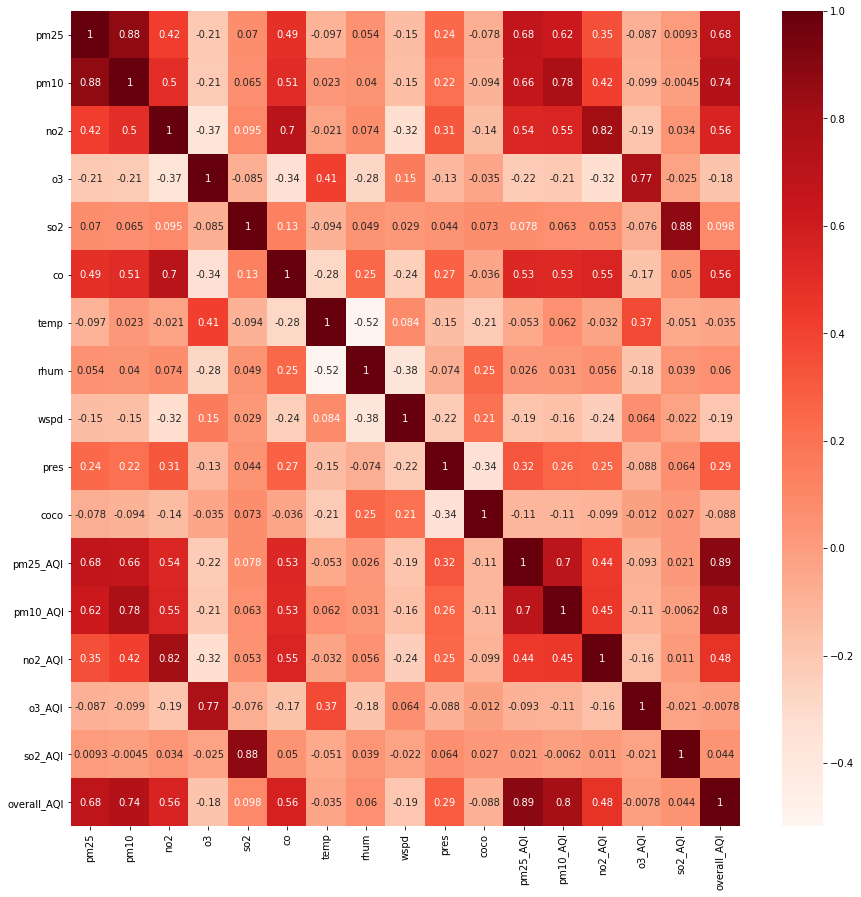

In [10]:
plt.figure(figsize=(15,15))
cor = final_df.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Spearman's rho

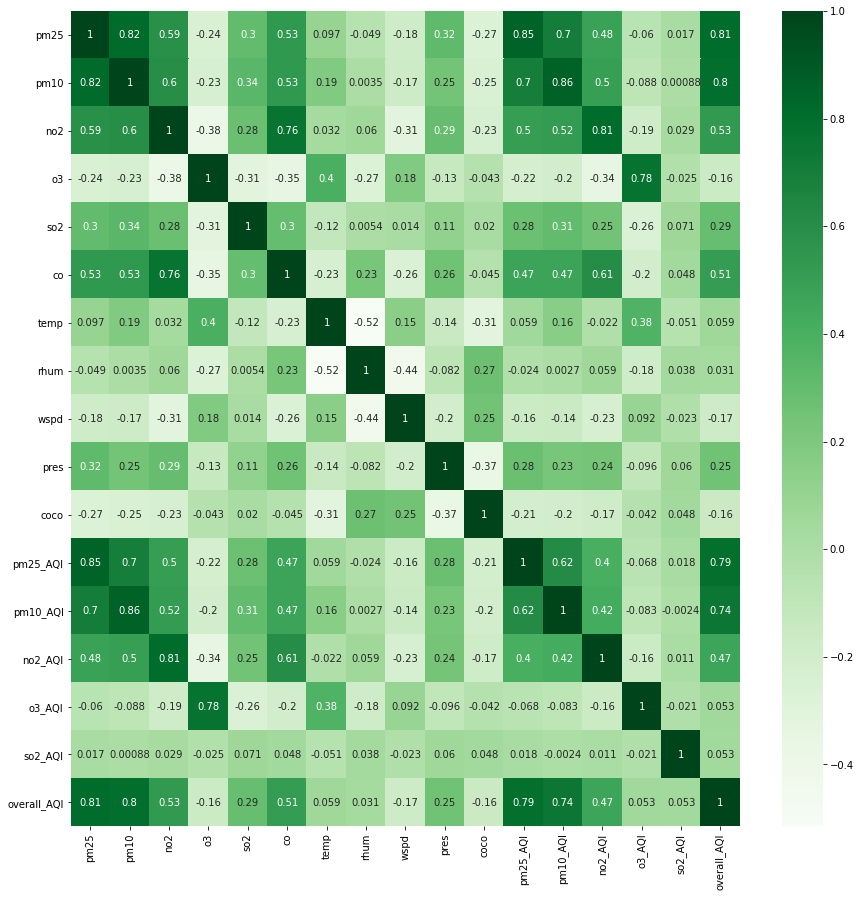

In [11]:
plt.figure(figsize=(15,15))
cor = final_df.corr(method='spearman')
sns.heatmap(cor, annot=True, cmap=plt.cm.Greens)
plt.show()

## Kendall's tau

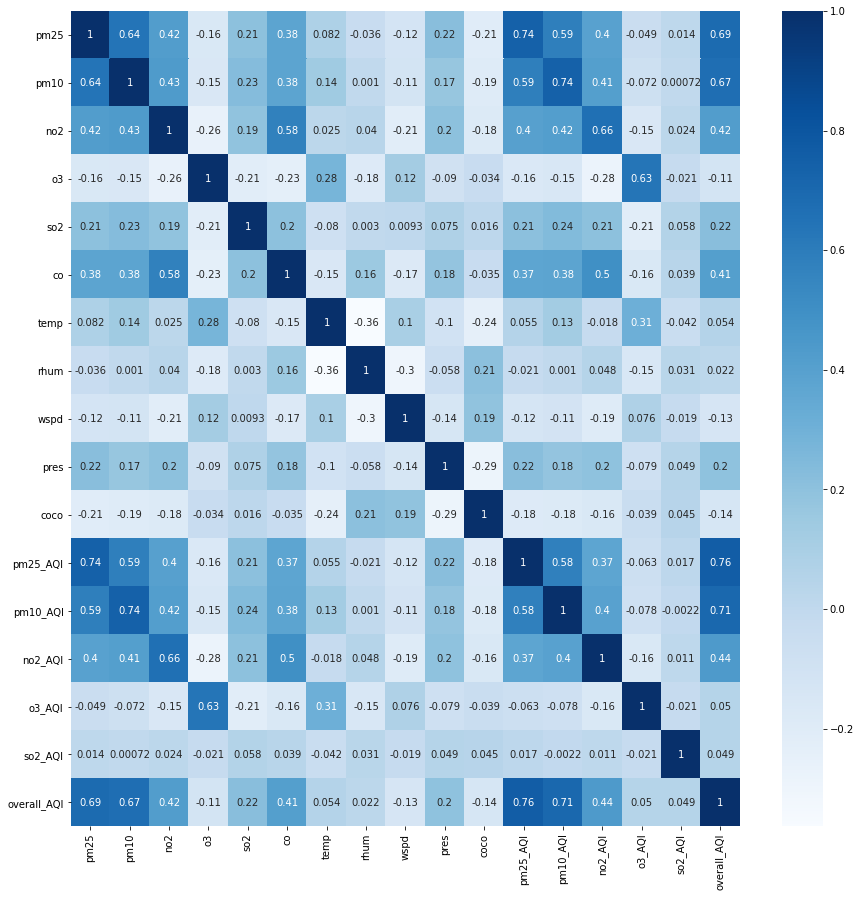

In [12]:
plt.figure(figsize=(15,15))
cor = final_df.corr(method='kendall')
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

# Data Preparation for Machine Learning Models

In [13]:
final_df.columns

Index(['pm25', 'pm10', 'no2', 'o3', 'so2', 'co', 'temp', 'rhum', 'wspd',
       'pres', 'coco', 'pm25_AQI', 'pm10_AQI', 'no2_AQI', 'o3_AQI', 'so2_AQI',
       'overall_AQI'],
      dtype='object')

In [14]:
dataset = final_df.copy()
dataset

pm25       pm10        no2         o3    so2  \
2020-05-20 02:00:00   5.100000  17.000000  10.503333  54.000000  0.555   
2020-05-20 03:00:00  13.000000  14.850000   9.445000  62.580002  0.565   
2020-05-20 04:00:00   9.050000  15.925000  13.510000  58.290001  0.380   
2020-05-20 05:00:00  12.700000  23.100000   4.930000  58.290001  0.500   
2020-05-20 06:00:00   5.550000  18.799999   7.423333  42.209999  0.500   
...                        ...        ...        ...        ...    ...   
2021-10-01 20:00:00  22.200001  37.900002  54.292000  40.610001  5.145   
2021-10-01 21:00:00  21.450001  33.700001  62.785000  36.110001  4.010   
2021-10-01 22:00:00  21.650000  40.433334  68.230003  32.599998  4.180   
2021-10-01 23:00:00  21.750000  34.200001  63.921665  35.125519  3.460   
2021-10-02 00:00:00  26.549999  40.933334  56.923332  20.290001  3.335   

                             co       temp       rhum  wspd         pres  \
2020-05-20 02:00:00  297.500000  17.400000  83.300003   7.5  1008.000000   
2020-05-20 03:00:00  340.000000  16.600000  87.199997   5.4  1008.200012   
2020-05-20 04:00:00  290.000000  16.400000  88.099998   9.3  1008.000000   
2020-05-20 05:00:00  309.166656  17.400000  83.300003   5.4  1008.000000   
2020-05-20 06:00:00  215.000000  16.700001  91.800003   1.9  1007.900024   
...                         ...        ...        ...   ...          ...   
2021-10-01 20:00:00  745.000000  21.600000  61.599998   6.9  1020.000000   
2021-10-01 21:00:00  866.666687  20.600000  68.500000   6.2  1019.900024   
2021-10-01 22:00:00  690.000000  19.600000  73.000000   4.4  1019.000000   
2021-10-01 23:00:00  750.000000  19.600000  73.400002   7.1  1019.000000   
2021-10-02 00:00:00  650.000000  19.600000  69.099998   6.1  1019.000000   

                     coco  pm25_AQI  pm10_AQI  no2_AQI  o3_AQI  so2_AQI  \
2020-05-20 02:00:00   7.0       1.0       1.0      1.0     2.0      1.0   
2020-05-20 03:00:00   7.0       2.0       1.0      1.0     2.0      1.0   
2020-05-20 04:00:00   7.0       1.0       1.0      1.0     2.0      1.0   
2020-05-20 05:00:00   7.0       2.0       2.0      1.0     2.0      1.0   
2020-05-20 06:00:00   7.0       1.0       1.0      1.0     1.0      1.0   
...                   ...       ...       ...      ...     ...      ...   
2021-10-01 20:00:00   1.0       3.0       2.0      2.0     1.0      1.0   
2021-10-01 21:00:00   1.0       3.0       2.0      2.0     1.0      1.0   
2021-10-01 22:00:00   1.0       3.0       1.0      2.0     1.0      1.0   
2021-10-01 23:00:00   1.0       3.0       2.0      2.0     1.0      1.0   
2021-10-02 00:00:00   1.0       4.0       1.0      2.0     1.0      1.0   

                     overall_AQI  
2020-05-20 02:00:00          2.0  
2020-05-20 03:00:00          2.0  
2020-05-20 04:00:00          2.0  
2020-05-20 05:00:00          2.0  
2020-05-20 06:00:00          1.0  
...                          ...  
2021-10-01 20:00:00          3.0  
2021-10-01 21:00:00          3.0  
2021-10-01 22:00:00          3.0  
2021-10-01 23:00:00          3.0  
2021-10-02 00:00:00          4.0  

[11999 rows x 17 columns]

### Split Data

In [15]:
from sklearn.model_selection import train_test_split

features=dataset.values
targets=dataset[["pm25", "pm10", "no2", "o3", "so2"]].values

X_train, X_test, y_train, y_test  = train_test_split(features, targets, test_size=0.1, random_state=1, shuffle=False)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1, random_state=1, shuffle=False)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (9719, 17)
X_test: (1200, 17)


### Normalize Data

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_val = scaler.transform(X_val)

X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((9719, 17), (1200, 17))

### Set up data with TimeseriesGenerator

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

win_length=12
batch_size=4
num_features=features.shape[1]

train_generator = TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

train_generator[0]

(array([[[0.00667845, 0.01915601, 0.08800447, 0.4050709 , 0.00560169,
          0.07422548, 0.5131579 , 0.7965896 , 0.15090543, 0.31941032,
          0.23076925, 0.        , 0.        , 0.        , 0.33333334,
          0.        , 0.2       ],
         [0.01702351, 0.01673334, 0.07913699, 0.46943218, 0.00562488,
          0.08519794, 0.49210528, 0.8440926 , 0.10865191, 0.32432556,
          0.23076925, 0.2       , 0.        , 0.        , 0.33333334,
          0.        , 0.2       ],
         [0.01185098, 0.01794467, 0.11319648, 0.43725154, 0.00519577,
          0.07228916, 0.4868421 , 0.85505486, 0.18712273, 0.31941032,
          0.23076925, 0.        , 0.        , 0.        , 0.33333334,
          0.        , 0.2       ],
         [0.01663066, 0.02602964, 0.04130708, 0.43725154, 0.00547411,
          0.07723752, 0.5131579 , 0.7965896 , 0.10865191, 0.31941032,
          0.23076925, 0.2       , 0.2       , 0.        , 0.33333334,
          0.        , 0.2       ],
         [0.00726773

# Create LSTM model

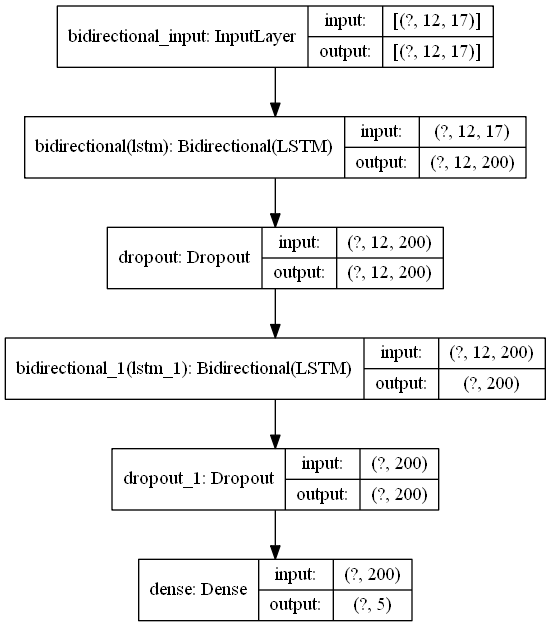

In [18]:
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,  return_sequences=True), input_shape=(win_length, num_features)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(targets.shape[1])
])

model_LSTM.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),loss=tf.losses.MeanSquaredLogarithmicError())

tf.keras.utils.plot_model(model=model_LSTM, show_shapes=True)

In [19]:
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

with tf.device('/GPU:0'):
    prepared_model = model_LSTM.fit(train_generator, 
                                    validation_data=test_generator,
                                    epochs=200, 
                                    shuffle=False,  
                                    callbacks=[lr_monitor, early_stopping])

Epoch 1/200
2427/2427 [==============================] - 34s 14ms/step - loss: 0.3562 - val_loss: 0.1566
Epoch 2/200
2427/2427 [==============================] - 32s 13ms/step - loss: 0.2720 - val_loss: 0.1130
Epoch 3/200
2427/2427 [==============================] - 32s 13ms/step - loss: 0.1957 - val_loss: 0.1124
Epoch 4/200
2427/2427 [==============================] - 34s 14ms/step - loss: 0.1829 - val_loss: 0.1142
Epoch 5/200
2427/2427 [==============================] - 33s 14ms/step - loss: 0.1742 - val_loss: 0.0978
Epoch 6/200
2427/2427 [==============================] - 34s 14ms/step - loss: 0.1678 - val_loss: 0.0958
Epoch 7/200
2427/2427 [==============================] - 33s 14ms/step - loss: 0.1640 - val_loss: 0.0958
Epoch 8/200
2427/2427 [==============================] - 34s 14ms/step - loss: 0.1588 - val_loss: 0.0967
Epoch 9/200
2427/2427 [==============================] - 33s 14ms/step - loss: 0.1541 - val_loss: 0.0853
Epoch 10/200
2427/2427 [==============================]

Text(0, 0.5, 'mse score')

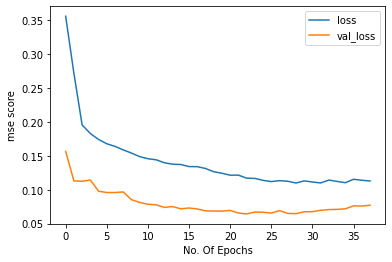

In [20]:
plt.plot(prepared_model.history["loss"],label="loss")
plt.plot(prepared_model.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [21]:
model_LSTM.evaluate(test_generator, verbose=1)

297/297 [==============================] - 1s 5ms/step - loss: 0.0642


0.06423579901456833

### Get Predictions

In [22]:
predictions=model_LSTM.predict(test_generator)

pd.DataFrame(predictions)

0          1          2          3         4
0     34.850239  64.885101  43.519966  51.850967  4.035767
1     34.539593  64.800606  42.628357  49.258606  3.940489
2     28.786001  54.582207  28.522497  63.045574  3.587318
3     33.166439  62.768066  43.241837  68.271561  4.367235
4     33.286823  62.498096  43.763401  71.872437  4.422831
...         ...        ...        ...        ...       ...
1183  21.833014  35.162083  45.367001  40.581577  3.817393
1184  22.391647  36.361870  49.646591  35.889797  3.864608
1185  22.977873  37.709759  52.576504  31.881905  3.862773
1186  21.661535  35.834396  54.326584  27.979494  3.792794
1187  22.373003  36.923512  51.110985  30.023540  3.813635

[1188 rows x 5 columns]

In [23]:
df_pred=pd.DataFrame(X_test[:,:][win_length:])

rev_trans=scaler.inverse_transform(df_pred)

df_final=dataset[rev_trans.shape[0]*-1:]

df_final[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions
df_final

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pm25       pm10        no2         o3       so2  \
2021-08-13 13:00:00  28.476830  54.735569  51.333237  46.782692  5.187683   
2021-08-13 14:00:00  24.400000  54.299999  16.650000  74.940002  5.187683   
2021-08-13 15:00:00  23.200001  59.599998  46.418335  82.379997  5.795000   
2021-08-13 16:00:00  35.000000  57.533333  49.125999  91.940002  5.740000   
2021-08-13 17:00:00  32.799999  58.166668  34.841999  81.059998  5.710000   
...                        ...        ...        ...        ...       ...   
2021-10-01 20:00:00  22.200001  37.900002  54.292000  40.610001  5.145000   
2021-10-01 21:00:00  21.450001  33.700001  62.785000  36.110001  4.010000   
2021-10-01 22:00:00  21.650000  40.433334  68.230003  32.599998  4.180000   
2021-10-01 23:00:00  21.750000  34.200001  63.921665  35.125519  3.460000   
2021-10-02 00:00:00  26.549999  40.933334  56.923332  20.290001  3.335000   

                             co       temp       rhum  wspd         pres  ...  \
2021-08-13 13:00:00  476.174713  35.799999  35.000000  11.4  1019.000000  ...   
2021-08-13 14:00:00  410.000000  35.799999  33.000000  12.9  1019.000000  ...   
2021-08-13 15:00:00  555.000000  36.099998  32.200001  11.4  1019.299988  ...   
2021-08-13 16:00:00  556.666687  34.000000  36.400002  15.8  1018.900024  ...   
2021-08-13 17:00:00  460.000000  32.200001  44.299999   9.1  1018.900024  ...   
...                         ...        ...        ...   ...          ...  ...   
2021-10-01 20:00:00  745.000000  21.600000  61.599998   6.9  1020.000000  ...   
2021-10-01 21:00:00  866.666687  20.600000  68.500000   6.2  1019.900024  ...   
2021-10-01 22:00:00  690.000000  19.600000  73.000000   4.4  1019.000000  ...   
2021-10-01 23:00:00  750.000000  19.600000  73.400002   7.1  1019.000000  ...   
2021-10-02 00:00:00  650.000000  19.600000  69.099998   6.1  1019.000000  ...   

                     pm10_AQI  no2_AQI  o3_AQI  so2_AQI  overall_AQI  \
2021-08-13 13:00:00       4.0      2.0     1.0      1.0          4.0   
2021-08-13 14:00:00       4.0      1.0     2.0      1.0          4.0   
2021-08-13 15:00:00       4.0      2.0     2.0      1.0          4.0   
2021-08-13 16:00:00       4.0      2.0     2.0      1.0          4.0   
2021-08-13 17:00:00       4.0      1.0     2.0      1.0          4.0   
...                       ...      ...     ...      ...          ...   
2021-10-01 20:00:00       2.0      2.0     1.0      1.0          3.0   
2021-10-01 21:00:00       2.0      2.0     1.0      1.0          3.0   
2021-10-01 22:00:00       1.0      2.0     1.0      1.0          3.0   
2021-10-01 23:00:00       2.0      2.0     1.0      1.0          3.0   
2021-10-02 00:00:00       1.0      2.0     1.0      1.0          4.0   

                     pm25_pred  pm10_pred   no2_pred    o3_pred  so2_pred  
2021-08-13 13:00:00  34.850239  64.885101  43.519966  51.850967  4.035767  
2021-08-13 14:00:00  34.539593  64.800606  42.628357  49.258606  3.940489  
2021-08-13 15:00:00  28.786001  54.582207  28.522497  63.045574  3.587318  
2021-08-13 16:00:00  33.166439  62.768066  43.241837  68.271561  4.367235  
2021-08-13 17:00:00  33.286823  62.498096  43.763401  71.872437  4.422831  
...                        ...        ...        ...        ...       ...  
2021-10-01 20:00:00  21.833014  35.162083  45.367001  40.581577  3.817393  
2021-10-01 21:00:00  22.391647  36.361870  49.646591  35.889797  3.864608  
2021-10-01 22:00:00  22.977873  37.709759  52.576504  31.881905  3.862773  
2021-10-01 23:00:00  21.661535  35.834396  54.326584  27.979494  3.792794  
2021-10-02 00:00:00  22.373003  36.923512  51.110985  30.023540  3.813635  

[1188 rows x 22 columns]

<AxesSubplot:>

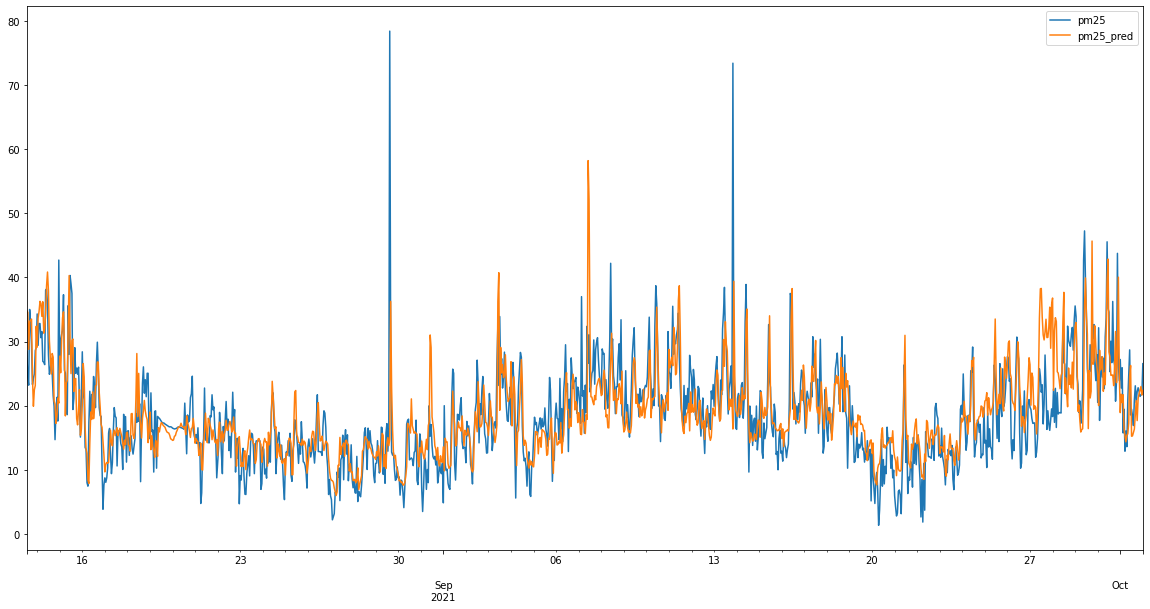

In [24]:
df_final[["pm25","pm25_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

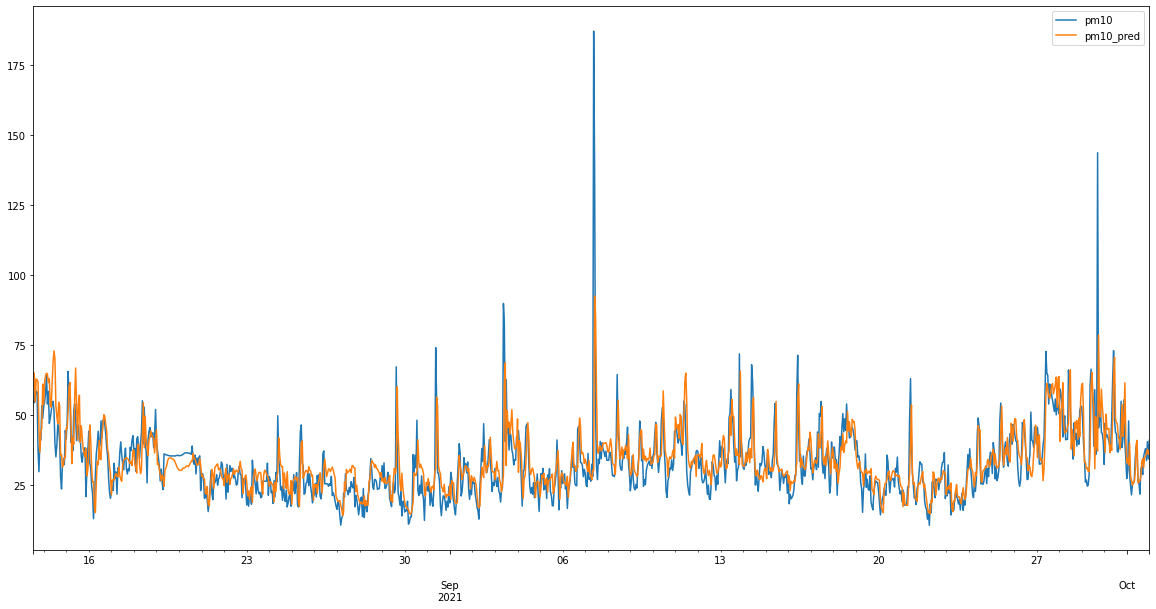

In [25]:
df_final[["pm10","pm10_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

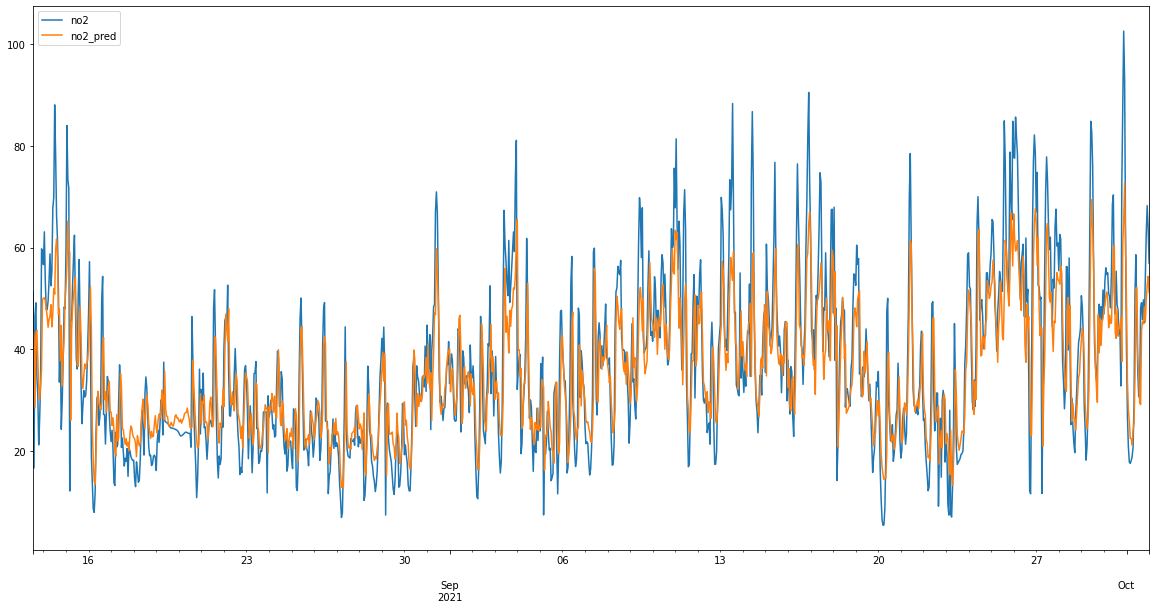

In [26]:
df_final[["no2","no2_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

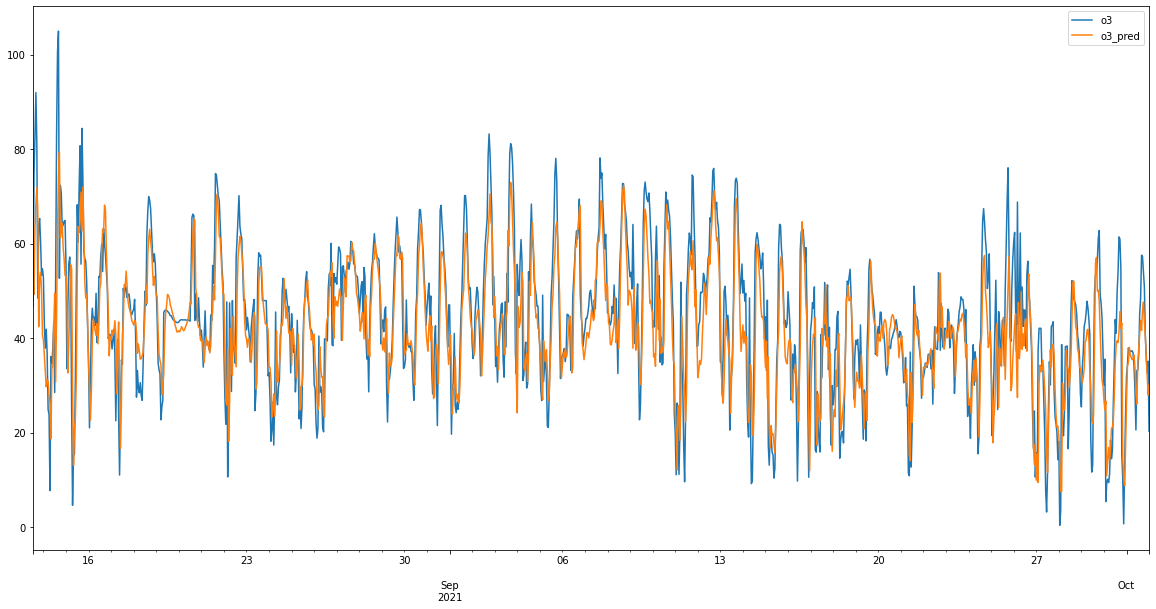

In [27]:
df_final[["o3","o3_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

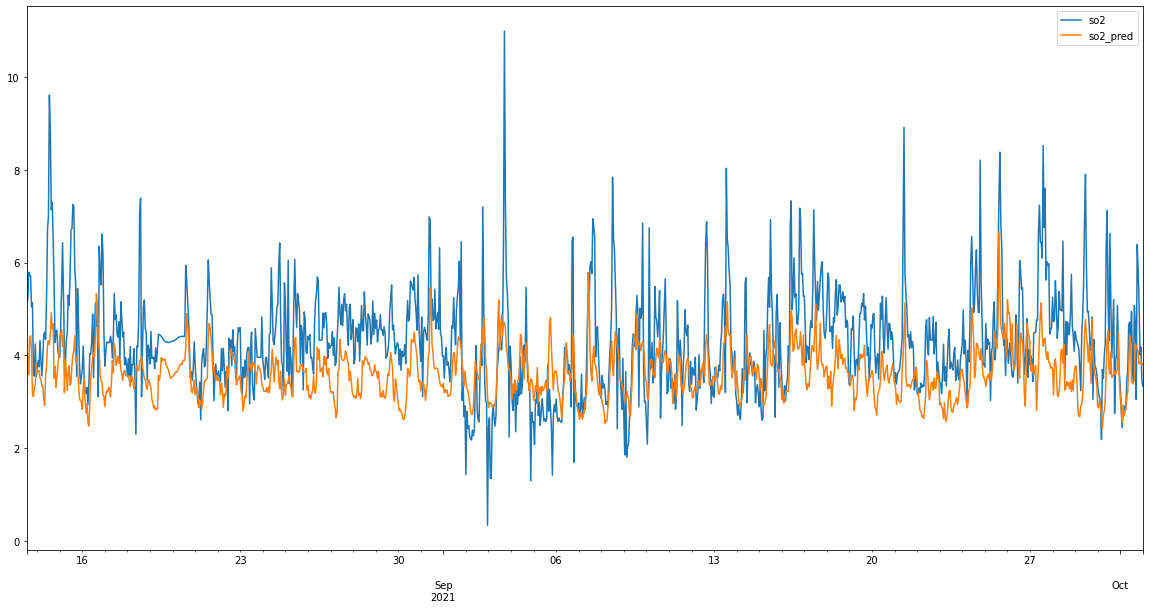

In [28]:
df_final[["so2","so2_pred"]].plot(figsize=(20,10))

# Create CNN Model

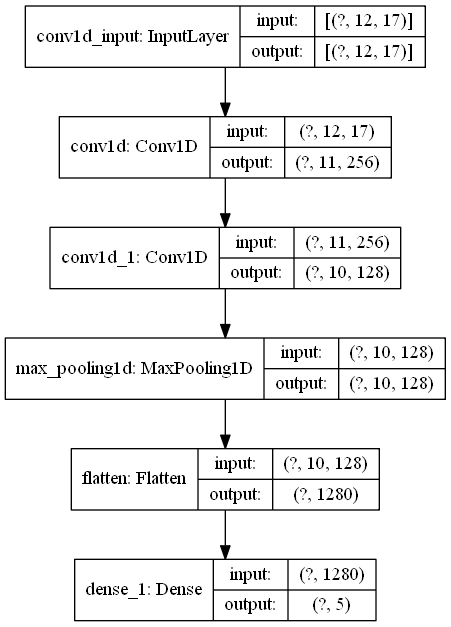

In [29]:
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=256, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.3), input_shape=(win_length, num_features)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    tf.keras.layers.MaxPooling1D(pool_size=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(targets.shape[1])
])

model_CNN.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),loss=tf.losses.MeanSquaredLogarithmicError())

tf.keras.utils.plot_model(model=model_CNN, show_shapes=True)

In [30]:
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

with tf.device('/GPU:0'):
    prepared_model_CNN = model_CNN.fit(train_generator, 
                                       validation_data=test_generator,
                                       epochs=400, 
                                       shuffle=False,  
                                       callbacks=[lr_monitor, early_stopping])

Epoch 1/400
2427/2427 [==============================] - 10s 4ms/step - loss: 2.8226 - val_loss: 0.1162
Epoch 2/400
2427/2427 [==============================] - 10s 4ms/step - loss: 0.2967 - val_loss: 0.1013
Epoch 3/400
2427/2427 [==============================] - 10s 4ms/step - loss: 0.3394 - val_loss: 0.0978
Epoch 4/400
2427/2427 [==============================] - 10s 4ms/step - loss: 0.3659 - val_loss: 0.0940
Epoch 5/400
2427/2427 [==============================] - 10s 4ms/step - loss: 0.2682 - val_loss: 0.0833
Epoch 6/400
2427/2427 [==============================] - 10s 4ms/step - loss: 0.2651 - val_loss: 0.0830
Epoch 7/400
2427/2427 [==============================] - 10s 4ms/step - loss: 0.2905 - val_loss: 0.0788
Epoch 8/400
2427/2427 [==============================] - 10s 4ms/step - loss: 0.2697 - val_loss: 0.0840
Epoch 9/400
2427/2427 [==============================] - 9s 4ms/step - loss: 0.1417 - val_loss: 0.0810
Epoch 10/400
2427/2427 [==============================] - 10s 4ms

Text(0, 0.5, 'mse score')

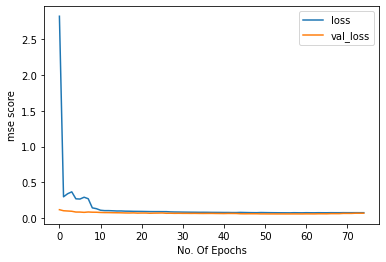

In [31]:
plt.plot(prepared_model_CNN.history["loss"],label="loss")
plt.plot(prepared_model_CNN.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [32]:
model_CNN.evaluate(test_generator, verbose=1)

297/297 [==============================] - 1s 2ms/step - loss: 0.0570


0.057003457099199295

### Get Predictions

In [33]:
predictions=model_CNN.predict(test_generator)

pd.DataFrame(predictions)

0          1          2          3         4
0     29.412825  57.858761  51.568039  54.597034  4.917409
1     29.853209  58.599026  51.897419  54.821964  4.799099
2     24.806448  52.704357  34.133141  77.774429  4.572006
3     30.330648  65.020393  44.173893  74.873184  4.994873
4     33.145321  60.829842  44.306396  80.781311  4.949587
...         ...        ...        ...        ...       ...
1183  22.720161  34.222065  45.174438  46.141273  4.137347
1184  23.565435  35.402233  51.453381  42.099873  3.673510
1185  22.084030  36.371933  56.601048  36.835926  4.006456
1186  25.051117  37.207653  60.642941  32.185966  4.159716
1187  23.984613  36.506660  54.299747  32.714771  3.569213

[1188 rows x 5 columns]

In [34]:
df_pred=pd.DataFrame(X_test[:,:][win_length:])

rev_trans=scaler.inverse_transform(df_pred)

df_final=dataset[rev_trans.shape[0]*-1:]

df_final[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions
df_final

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pm25       pm10        no2         o3       so2  \
2021-08-13 13:00:00  28.476830  54.735569  51.333237  46.782692  5.187683   
2021-08-13 14:00:00  24.400000  54.299999  16.650000  74.940002  5.187683   
2021-08-13 15:00:00  23.200001  59.599998  46.418335  82.379997  5.795000   
2021-08-13 16:00:00  35.000000  57.533333  49.125999  91.940002  5.740000   
2021-08-13 17:00:00  32.799999  58.166668  34.841999  81.059998  5.710000   
...                        ...        ...        ...        ...       ...   
2021-10-01 20:00:00  22.200001  37.900002  54.292000  40.610001  5.145000   
2021-10-01 21:00:00  21.450001  33.700001  62.785000  36.110001  4.010000   
2021-10-01 22:00:00  21.650000  40.433334  68.230003  32.599998  4.180000   
2021-10-01 23:00:00  21.750000  34.200001  63.921665  35.125519  3.460000   
2021-10-02 00:00:00  26.549999  40.933334  56.923332  20.290001  3.335000   

                             co       temp       rhum  wspd         pres  ...  \
2021-08-13 13:00:00  476.174713  35.799999  35.000000  11.4  1019.000000  ...   
2021-08-13 14:00:00  410.000000  35.799999  33.000000  12.9  1019.000000  ...   
2021-08-13 15:00:00  555.000000  36.099998  32.200001  11.4  1019.299988  ...   
2021-08-13 16:00:00  556.666687  34.000000  36.400002  15.8  1018.900024  ...   
2021-08-13 17:00:00  460.000000  32.200001  44.299999   9.1  1018.900024  ...   
...                         ...        ...        ...   ...          ...  ...   
2021-10-01 20:00:00  745.000000  21.600000  61.599998   6.9  1020.000000  ...   
2021-10-01 21:00:00  866.666687  20.600000  68.500000   6.2  1019.900024  ...   
2021-10-01 22:00:00  690.000000  19.600000  73.000000   4.4  1019.000000  ...   
2021-10-01 23:00:00  750.000000  19.600000  73.400002   7.1  1019.000000  ...   
2021-10-02 00:00:00  650.000000  19.600000  69.099998   6.1  1019.000000  ...   

                     pm10_AQI  no2_AQI  o3_AQI  so2_AQI  overall_AQI  \
2021-08-13 13:00:00       4.0      2.0     1.0      1.0          4.0   
2021-08-13 14:00:00       4.0      1.0     2.0      1.0          4.0   
2021-08-13 15:00:00       4.0      2.0     2.0      1.0          4.0   
2021-08-13 16:00:00       4.0      2.0     2.0      1.0          4.0   
2021-08-13 17:00:00       4.0      1.0     2.0      1.0          4.0   
...                       ...      ...     ...      ...          ...   
2021-10-01 20:00:00       2.0      2.0     1.0      1.0          3.0   
2021-10-01 21:00:00       2.0      2.0     1.0      1.0          3.0   
2021-10-01 22:00:00       1.0      2.0     1.0      1.0          3.0   
2021-10-01 23:00:00       2.0      2.0     1.0      1.0          3.0   
2021-10-02 00:00:00       1.0      2.0     1.0      1.0          4.0   

                     pm25_pred  pm10_pred   no2_pred    o3_pred  so2_pred  
2021-08-13 13:00:00  29.412825  57.858761  51.568039  54.597034  4.917409  
2021-08-13 14:00:00  29.853209  58.599026  51.897419  54.821964  4.799099  
2021-08-13 15:00:00  24.806448  52.704357  34.133141  77.774429  4.572006  
2021-08-13 16:00:00  30.330648  65.020393  44.173893  74.873184  4.994873  
2021-08-13 17:00:00  33.145321  60.829842  44.306396  80.781311  4.949587  
...                        ...        ...        ...        ...       ...  
2021-10-01 20:00:00  22.720161  34.222065  45.174438  46.141273  4.137347  
2021-10-01 21:00:00  23.565435  35.402233  51.453381  42.099873  3.673510  
2021-10-01 22:00:00  22.084030  36.371933  56.601048  36.835926  4.006456  
2021-10-01 23:00:00  25.051117  37.207653  60.642941  32.185966  4.159716  
2021-10-02 00:00:00  23.984613  36.506660  54.299747  32.714771  3.569213  

[1188 rows x 22 columns]

<AxesSubplot:>

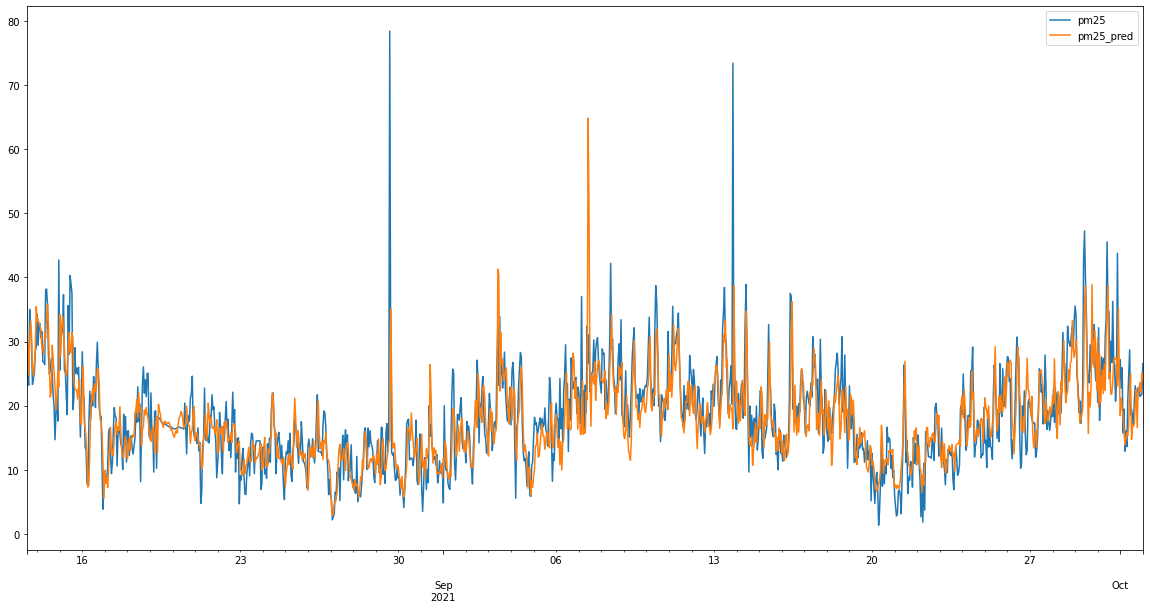

In [35]:
df_final[["pm25","pm25_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

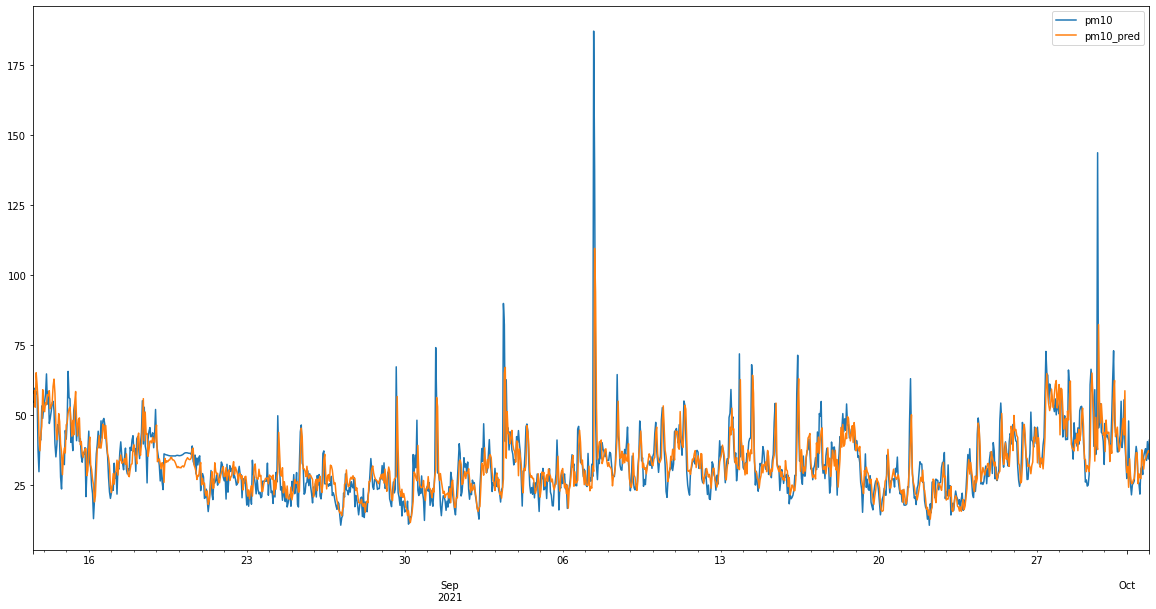

In [36]:
df_final[["pm10","pm10_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

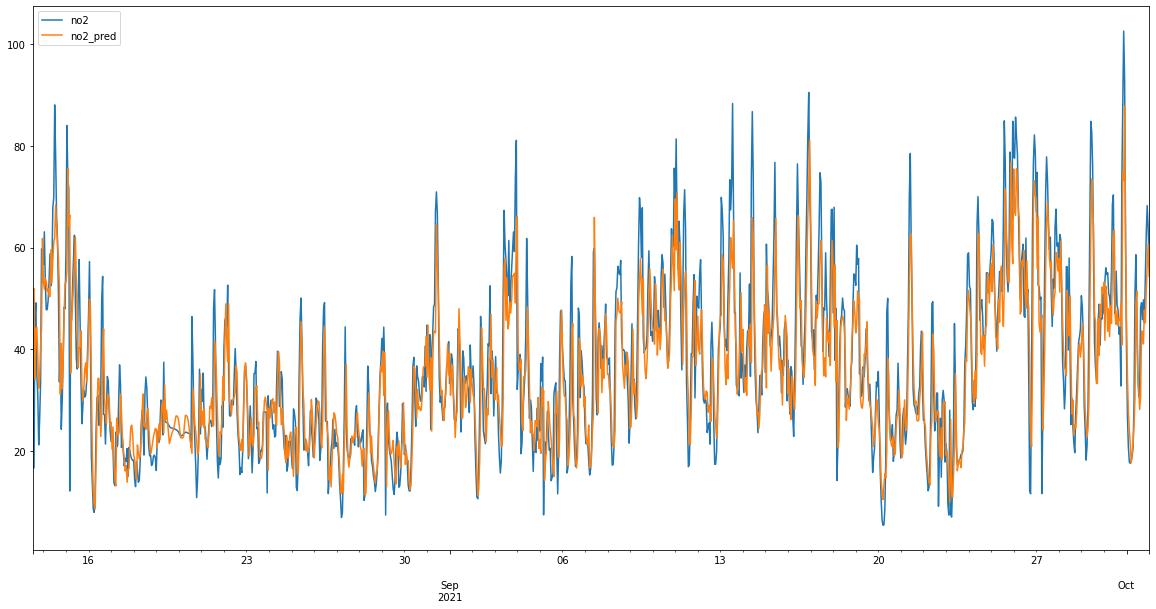

In [37]:
df_final[["no2","no2_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

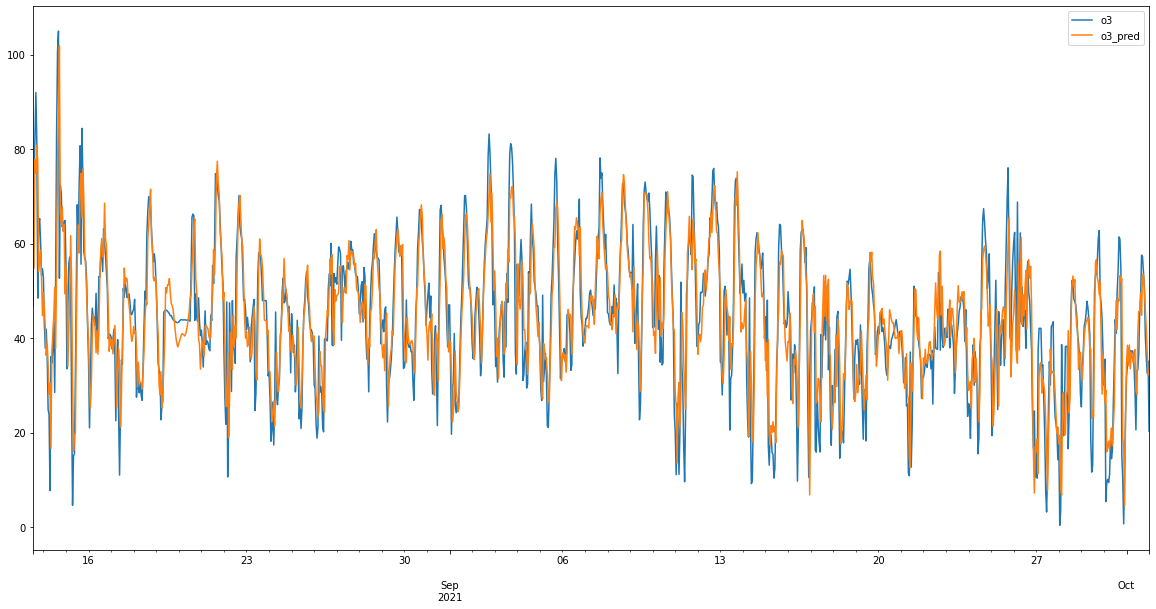

In [38]:
df_final[["o3","o3_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

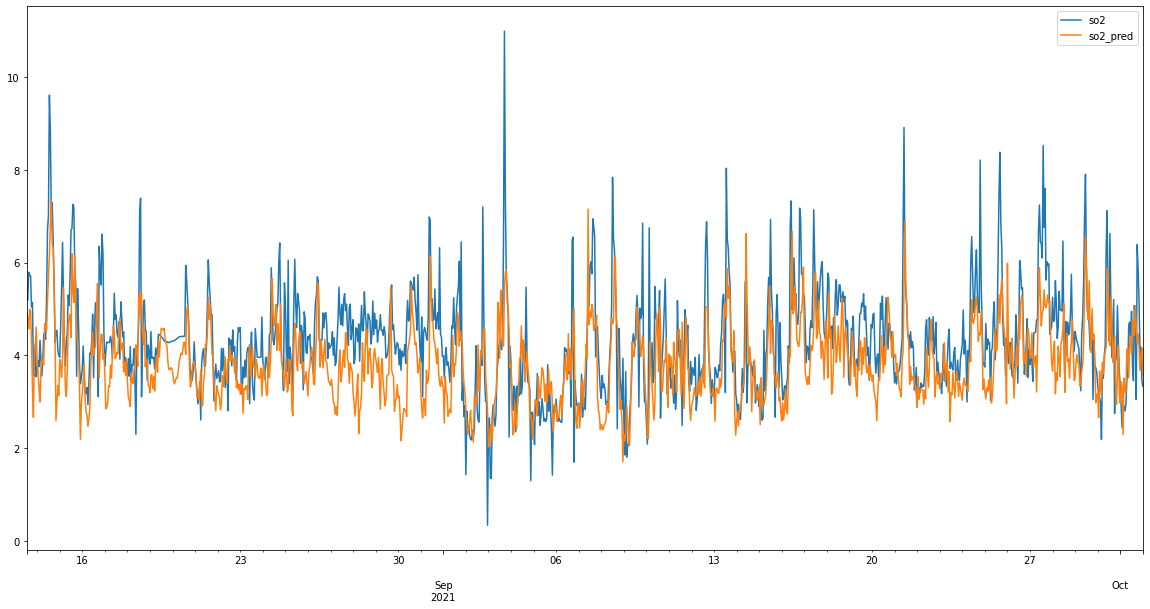

In [39]:
df_final[["so2","so2_pred"]].plot(figsize=(20,10))

# LSTM-CNN Model

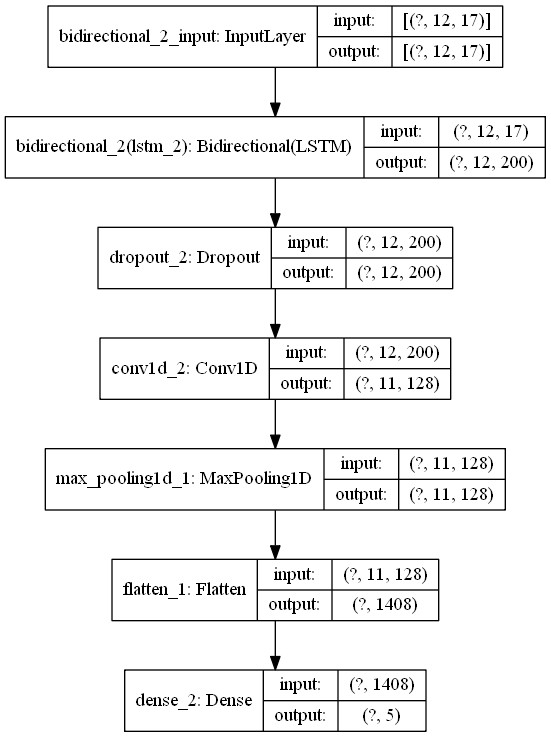

In [40]:
model_LSTMCNN = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), input_shape=(win_length, num_features)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.7)),
    tf.keras.layers.MaxPooling1D(pool_size=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(targets.shape[1])
])

model_LSTMCNN.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),loss=tf.losses.MeanSquaredLogarithmicError())

tf.keras.utils.plot_model(model=model_LSTMCNN, show_shapes=True)

In [41]:
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

with tf.device('/GPU:0'):
    prepared_model_LSTMCNN = model_LSTMCNN.fit(train_generator, 
                                       validation_data=test_generator,
                                       epochs=200, 
                                       shuffle=False,  
                                       callbacks=[lr_monitor, early_stopping])

Epoch 1/200
2427/2427 [==============================] - 22s 9ms/step - loss: 1.6094 - val_loss: 0.1186
Epoch 2/200
2427/2427 [==============================] - 21s 9ms/step - loss: 0.2772 - val_loss: 0.0977
Epoch 3/200
2427/2427 [==============================] - 21s 9ms/step - loss: 0.3086 - val_loss: 0.0871
Epoch 4/200
2427/2427 [==============================] - 22s 9ms/step - loss: 0.3824 - val_loss: 0.0906
Epoch 5/200
2427/2427 [==============================] - 2409s 993ms/step - loss: 0.3147 - val_loss: 0.0899
Epoch 6/200
2427/2427 [==============================] - 23s 9ms/step - loss: 0.2898 - val_loss: 0.0833
Epoch 7/200
2427/2427 [==============================] - 23s 9ms/step - loss: 0.2667 - val_loss: 0.0867
Epoch 8/200
2427/2427 [==============================] - 22s 9ms/step - loss: 0.2804 - val_loss: 0.0800
Epoch 9/200
2427/2427 [==============================] - 21s 9ms/step - loss: 0.2645 - val_loss: 0.0780
Epoch 10/200
2427/2427 [==============================] - 21

Text(0, 0.5, 'mse score')

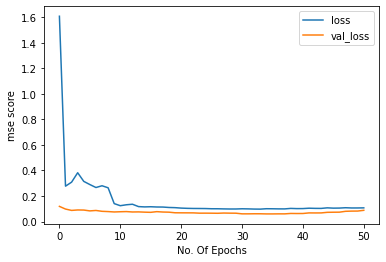

In [42]:
plt.plot(prepared_model_LSTMCNN.history["loss"],label="loss")
plt.plot(prepared_model_LSTMCNN.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [43]:
model_LSTMCNN.evaluate(test_generator, verbose=1)

297/297 [==============================] - 1s 3ms/step - loss: 0.0596


0.05960407853126526

### Get Predictions

In [44]:
predictions=model_CNN.predict(test_generator)

pd.DataFrame(predictions)

0          1          2          3         4
0     29.412825  57.858761  51.568039  54.597034  4.917409
1     29.853209  58.599026  51.897419  54.821964  4.799099
2     24.806448  52.704357  34.133141  77.774429  4.572006
3     30.330648  65.020393  44.173893  74.873184  4.994873
4     33.145321  60.829842  44.306396  80.781311  4.949587
...         ...        ...        ...        ...       ...
1183  22.720161  34.222065  45.174438  46.141273  4.137347
1184  23.565435  35.402233  51.453381  42.099873  3.673510
1185  22.084030  36.371933  56.601048  36.835926  4.006456
1186  25.051117  37.207653  60.642941  32.185966  4.159716
1187  23.984613  36.506660  54.299747  32.714771  3.569213

[1188 rows x 5 columns]

In [45]:
df_pred=pd.DataFrame(X_test[:,:][win_length:])

rev_trans=scaler.inverse_transform(df_pred)

df_final=dataset[rev_trans.shape[0]*-1:]

df_final[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions
df_final

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pm25       pm10        no2         o3       so2  \
2021-08-13 13:00:00  28.476830  54.735569  51.333237  46.782692  5.187683   
2021-08-13 14:00:00  24.400000  54.299999  16.650000  74.940002  5.187683   
2021-08-13 15:00:00  23.200001  59.599998  46.418335  82.379997  5.795000   
2021-08-13 16:00:00  35.000000  57.533333  49.125999  91.940002  5.740000   
2021-08-13 17:00:00  32.799999  58.166668  34.841999  81.059998  5.710000   
...                        ...        ...        ...        ...       ...   
2021-10-01 20:00:00  22.200001  37.900002  54.292000  40.610001  5.145000   
2021-10-01 21:00:00  21.450001  33.700001  62.785000  36.110001  4.010000   
2021-10-01 22:00:00  21.650000  40.433334  68.230003  32.599998  4.180000   
2021-10-01 23:00:00  21.750000  34.200001  63.921665  35.125519  3.460000   
2021-10-02 00:00:00  26.549999  40.933334  56.923332  20.290001  3.335000   

                             co       temp       rhum  wspd         pres  ...  \
2021-08-13 13:00:00  476.174713  35.799999  35.000000  11.4  1019.000000  ...   
2021-08-13 14:00:00  410.000000  35.799999  33.000000  12.9  1019.000000  ...   
2021-08-13 15:00:00  555.000000  36.099998  32.200001  11.4  1019.299988  ...   
2021-08-13 16:00:00  556.666687  34.000000  36.400002  15.8  1018.900024  ...   
2021-08-13 17:00:00  460.000000  32.200001  44.299999   9.1  1018.900024  ...   
...                         ...        ...        ...   ...          ...  ...   
2021-10-01 20:00:00  745.000000  21.600000  61.599998   6.9  1020.000000  ...   
2021-10-01 21:00:00  866.666687  20.600000  68.500000   6.2  1019.900024  ...   
2021-10-01 22:00:00  690.000000  19.600000  73.000000   4.4  1019.000000  ...   
2021-10-01 23:00:00  750.000000  19.600000  73.400002   7.1  1019.000000  ...   
2021-10-02 00:00:00  650.000000  19.600000  69.099998   6.1  1019.000000  ...   

                     pm10_AQI  no2_AQI  o3_AQI  so2_AQI  overall_AQI  \
2021-08-13 13:00:00       4.0      2.0     1.0      1.0          4.0   
2021-08-13 14:00:00       4.0      1.0     2.0      1.0          4.0   
2021-08-13 15:00:00       4.0      2.0     2.0      1.0          4.0   
2021-08-13 16:00:00       4.0      2.0     2.0      1.0          4.0   
2021-08-13 17:00:00       4.0      1.0     2.0      1.0          4.0   
...                       ...      ...     ...      ...          ...   
2021-10-01 20:00:00       2.0      2.0     1.0      1.0          3.0   
2021-10-01 21:00:00       2.0      2.0     1.0      1.0          3.0   
2021-10-01 22:00:00       1.0      2.0     1.0      1.0          3.0   
2021-10-01 23:00:00       2.0      2.0     1.0      1.0          3.0   
2021-10-02 00:00:00       1.0      2.0     1.0      1.0          4.0   

                     pm25_pred  pm10_pred   no2_pred    o3_pred  so2_pred  
2021-08-13 13:00:00  29.412825  57.858761  51.568039  54.597034  4.917409  
2021-08-13 14:00:00  29.853209  58.599026  51.897419  54.821964  4.799099  
2021-08-13 15:00:00  24.806448  52.704357  34.133141  77.774429  4.572006  
2021-08-13 16:00:00  30.330648  65.020393  44.173893  74.873184  4.994873  
2021-08-13 17:00:00  33.145321  60.829842  44.306396  80.781311  4.949587  
...                        ...        ...        ...        ...       ...  
2021-10-01 20:00:00  22.720161  34.222065  45.174438  46.141273  4.137347  
2021-10-01 21:00:00  23.565435  35.402233  51.453381  42.099873  3.673510  
2021-10-01 22:00:00  22.084030  36.371933  56.601048  36.835926  4.006456  
2021-10-01 23:00:00  25.051117  37.207653  60.642941  32.185966  4.159716  
2021-10-02 00:00:00  23.984613  36.506660  54.299747  32.714771  3.569213  

[1188 rows x 22 columns]

<AxesSubplot:>

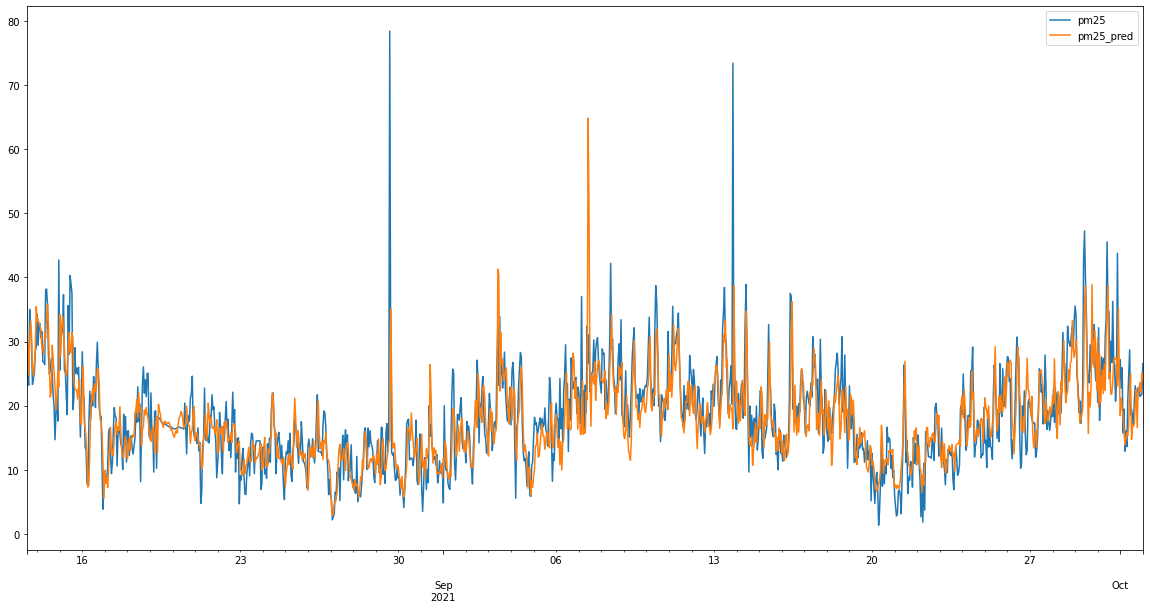

In [46]:
df_final[["pm25","pm25_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

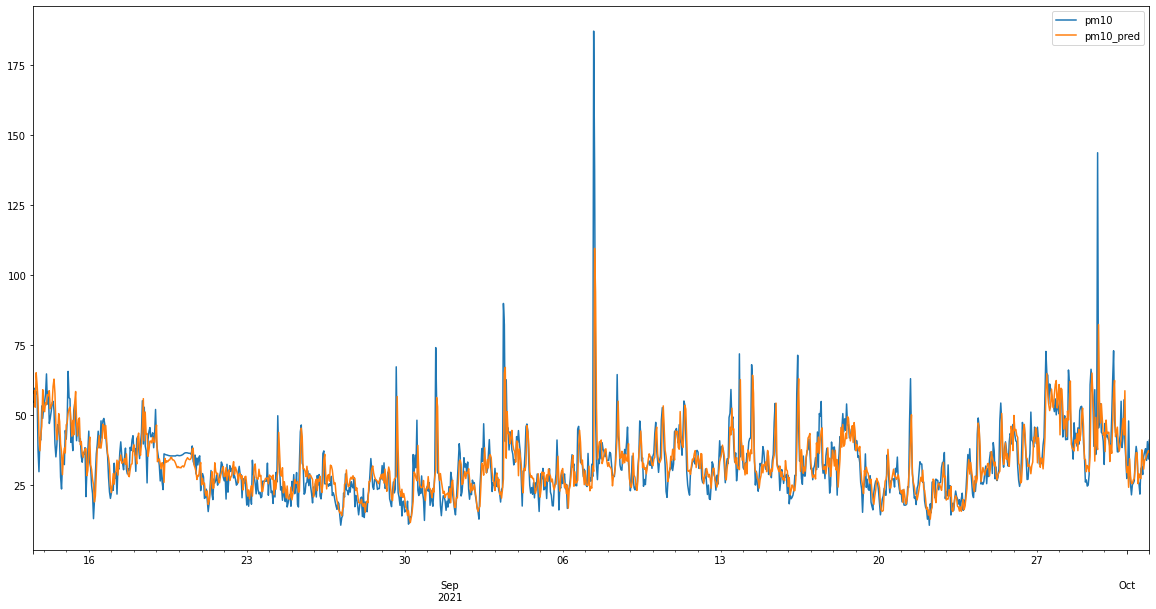

In [47]:
df_final[["pm10","pm10_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

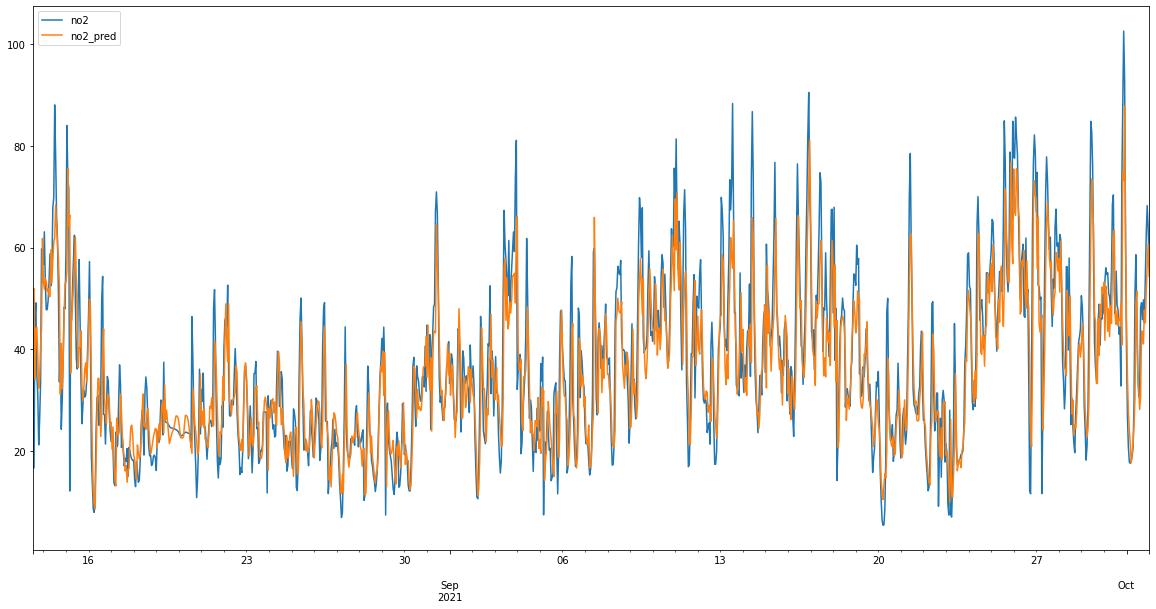

In [48]:
df_final[["no2","no2_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

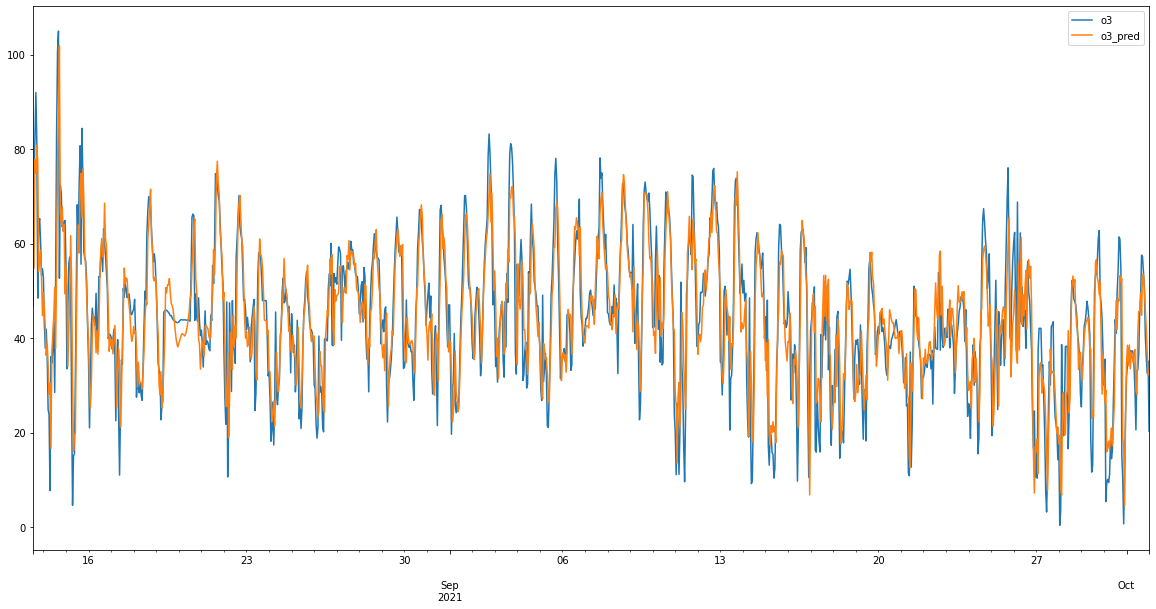

In [49]:
df_final[["o3","o3_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

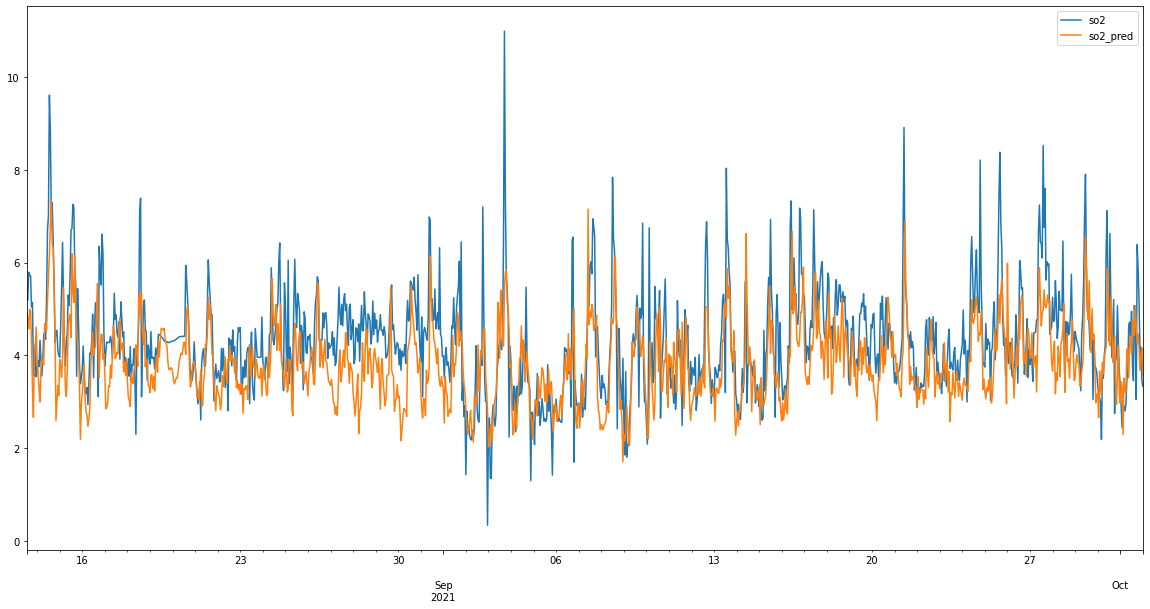

In [50]:
df_final[["so2","so2_pred"]].plot(figsize=(20,10))

In [51]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mslr = tf.keras.metrics.mean_squared_logarithmic_error(y_true, y_pred)
  
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mslr": mslr.numpy(),
           }

In [52]:
selected_features = ["pm25", "pm10", "no2", "o3", "so2"]

for feature in selected_features:
    print("-----{}-----".format(feature))
    print(evaluate_preds(y_true=df_final[feature].values,
                         y_pred=df_final["{}_pred".format(feature)].values)
         )

-----pm25-----
{'mae': 3.5108244, 'mse': 27.37324, 'rmse': 5.231944, 'mape': 22.479174, 'mslr': 0.06934653}
-----pm10-----
{'mae': 5.1306853, 'mse': 81.19148, 'rmse': 9.010632, 'mape': 15.824838, 'mslr': 0.042259037}
-----no2-----
{'mae': 6.225017, 'mse': 74.80358, 'rmse': 8.648907, 'mape': 19.81771, 'mslr': 0.06254463}
-----o3-----
{'mae': 6.0644608, 'mse': 68.484665, 'rmse': 8.275546, 'mape': 24.897333, 'mslr': 0.07667881}
-----so2-----
{'mae': 0.73799115, 'mse': 0.94340974, 'rmse': 0.9712928, 'mape': 17.500616, 'mslr': 0.03418824}
